<a href="https://www.kaggle.com/code/pedrobarrios/proyecto1-convolutional-kuzushijimnist?scriptVersionId=98634982" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Cargando librerias a usar
import torch
import torchvision
from torchvision import transforms, datasets

import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import helper

print("[INFO] Librerias cargadas")

[INFO] Librerias cargadas


Carga de datos del dataset de Kuzushiji-MNIST de Anokas

In [2]:
#Funcion de apoyo para adaptar la forma del dataset
def resize(data):
    data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])
    return data

print("[INFO] loading the KMNIST dataset...")
#Carga del dataset a arrays auxiliares
arr_train_img = np.load("../input/kuzushiji/kmnist-train-imgs.npz")['arr_0']
arr_train_label = np.load("../input/kuzushiji/kmnist-train-labels.npz")['arr_0']
arr_test_img = np.load("../input/kuzushiji/kmnist-test-imgs.npz")['arr_0']
arr_test_label = np.load("../input/kuzushiji/kmnist-test-labels.npz")['arr_0']

#Pasandolos a Tensor de pytorch
# A los labels aplicamos .type(torch.LongTensor para arreglar RuntimeError: expected scalar type Long but found Float
# Las imagenes las dividimos entre 255 para normalizarlas del rango [0,255] que es el rango de los valores de los pixeles
# de una imagen RGB al rango [0,1]
# Esta normalizacion tambien soluciona errores de NaN para el training Loss y baja precision para el training accuracy
train_images = torch.Tensor(arr_train_img)/255
train_labels = torch.Tensor(arr_train_label).type(torch.LongTensor)
test_images = torch.Tensor(arr_test_img)/255
test_labels = torch.Tensor(arr_test_label).type(torch.LongTensor)

#Cambiando la forma del Tensor de las imagenes para no tener shapes al estilo de [6000,]
train_images,test_images = resize(train_images),resize(test_images)

print("[INFO] KMNIST dataset 50% loaded")

[INFO] loading the KMNIST dataset...
[INFO] KMNIST dataset 50% loaded


In [3]:
#Verificando forma de la data importada y transformada
print("Imagenes")
print(train_images.shape)
print(test_images.shape)
print("Labels")
print(train_labels.shape)
print(test_labels.shape)

Imagenes
torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])
Labels
torch.Size([60000])
torch.Size([10000])


Clases, hiperparametros y Dataloader de pytorch estableciendo set de entrenamiento y set de pruebas

In [4]:
#HIPERPARAMETROS Y DEMAS

# Creando las clases para los diferentes familias de caracteres a clasificar
classes = ('O', 'Ki', 'Su', 'Tsu'
           , 'Na', 'Ha', 'Ma', 'Ya'
           , 'Re', 'Wo')

# Definimos el tamaños de los batch, los Epoch y el rate de aprendizaje
batch_size = 32
learning_rate = 0.01
epochs = 60 #Historial: 20 - 30 - 60
softmax_classes = len(classes)

#Conversion de Tensor a Dataset de pytorch
trainset = torch.utils.data.TensorDataset(train_images,train_labels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torch.utils.data.TensorDataset(test_images,test_labels)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

print("[INFO] KMNIST dataset loaded")

[INFO] KMNIST dataset loaded


MODELOS DE REDES NEURONALES

In [5]:
# Arquitectura V1
#Funciona bien
class ConvNN(nn.Module):
    def __init__(self, softmax_classes):
        super(ConvNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 3, stride = 1)
        
        self.fc1 = nn.Linear(18432, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, softmax_classes)
        
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.max_pool1(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = F.log_softmax(out,dim=1)
        return out
    
print("[INFO] Arquitectura V1 utilizada")

[INFO] Arquitectura V1 utilizada


In [6]:
# Arquitectura V2
#Mejora de V1 pero el stride 1 en el max pool lo hace demasiado lenta
class ConvNN(nn.Module):
    def __init__(self, softmax_classes):
        super(ConvNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 3, stride = 1)
        
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 3, stride = 1)
        
        self.fc1 = nn.Linear(25600, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, softmax_classes)
       
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.max_pool1(out)
        
        out = self.conv_layer2(out)
        out = self.max_pool2(out)
                
        out = torch.flatten(out,1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = F.log_softmax(out,dim=1)
        return out
    
print("[INFO] Arquitectura V2 utilizada")

[INFO] Arquitectura V2 utilizada


In [7]:
# Arquitectura V3
#Cambiando el stride de los max pool a 2 acelera el aprendizaje y obtenemos buenos resultados
class ConvNN(nn.Module):
    def __init__(self, softmax_classes):
        super(ConvNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        
        self.fc1 = nn.Linear(1024, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, softmax_classes)
       
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.max_pool1(out)
        
        out = self.conv_layer2(out)
        out = self.max_pool2(out)
                
        out = torch.flatten(out,1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = F.log_softmax(out,dim=1)
        return out
    
print("[INFO] Arquitectura V3 utilizada")

[INFO] Arquitectura V3 utilizada


In [8]:
# Arquitectura V4
# V3 con funciones V1 arrojo training acc de 99.algo y test acc de 93.algo, verificando que
#pasa si aplicamos batch norm
class ConvNN(nn.Module):
    def __init__(self, softmax_classes):
        super(ConvNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        
        self.fc1 = nn.Linear(1024, 128)
        self.relu1 = nn.ReLU()
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, softmax_classes)
       
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.bn1(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer2(out)
        out = self.bn2(out)
        out = self.max_pool2(out)
                
        out = torch.flatten(out,1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.bn3(out)
        out = self.fc2(out)
        out = F.log_softmax(out,dim=1)
        return out

#Resultados: test acc subio a 94.77 y train acc subio a 99.97 con 60 epochs
print("[INFO] Arquitectura V4 utilizada")

[INFO] Arquitectura V4 utilizada


In [9]:
# Arquitectura V5
# 1 conv layer mas sin el max pooling y se agrego 1 layer mas en la fully connected con activacion ReLU
class ConvNN(nn.Module):
    def __init__(self, softmax_classes):
        super(ConvNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 3, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(512, 128)
        self.relu1 = nn.ReLU()
        self.bn4 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, softmax_classes)
       
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.bn1(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer2(out)
        out = self.bn2(out)
        out = self.max_pool2(out)
        
        out = self.conv_layer3(out)
        out = self.bn3(out)
                
        out = torch.flatten(out,1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.bn4(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = F.log_softmax(out,dim=1)
        return out

#Resultados: test acc subio a 95.86 y train acc se quedo en 99.97 ~ 99.98 con 60 epochs
print("[INFO] Arquitectura V5 utilizada")

[INFO] Arquitectura V5 utilizada


In [10]:
# Modelo, funcion de perdida y optimizador V1
# Declaramos la red
model = ConvNN(softmax_classes)

# Definimos la metrica de la funcion de perdida
criterion = nn.CrossEntropyLoss()

# Seleccionamos nuestro optimizador
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
    print('[INFO] Usando CUDA para procesar data')
else:
    device = "cpu"
    print('[INFO] Usando CPU para procesar data')

print("[INFO] Modelo, funcion de perdida y optimizador V1 declarados")

[INFO] Usando CUDA para procesar data
[INFO] Modelo, funcion de perdida y optimizador V1 declarados


In [11]:
print("[INFO] Iniciando entrenamiento del modelo")
#Entrenamiento
model.train()
for e in range(epochs):
    trainLoss  = 0
    accuracy  = 0
    for (images, labels) in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        trainLoss += loss.item()
        _, predicted = torch.max(nn.functional.softmax(outputs, dim=1), 1)
        accuracy += (predicted == labels).sum()
        
    else:
        trainLoss = trainLoss/len(trainloader)
        accuracy = 100 * accuracy.cpu().numpy()/len(train_images)
        
        print('Epoch:{}/{} \t Training Loss:{:.6f} \t Training Acc:{:.2f}'.format(
            e+1, 
            epochs,
            trainLoss,
            accuracy
        ))
        
print("[INFO] Entrenamiento del modelo finalizado")

[INFO] Iniciando entrenamiento del modelo
Epoch:1/60 	 Training Loss:0.464999 	 Training Acc:88.06
Epoch:2/60 	 Training Loss:0.143713 	 Training Acc:95.83
Epoch:3/60 	 Training Loss:0.095762 	 Training Acc:97.22
Epoch:4/60 	 Training Loss:0.073430 	 Training Acc:97.84
Epoch:5/60 	 Training Loss:0.057730 	 Training Acc:98.35
Epoch:6/60 	 Training Loss:0.046379 	 Training Acc:98.69
Epoch:7/60 	 Training Loss:0.038260 	 Training Acc:98.94
Epoch:8/60 	 Training Loss:0.032558 	 Training Acc:99.06
Epoch:9/60 	 Training Loss:0.027338 	 Training Acc:99.26
Epoch:10/60 	 Training Loss:0.022856 	 Training Acc:99.37
Epoch:11/60 	 Training Loss:0.018873 	 Training Acc:99.50
Epoch:12/60 	 Training Loss:0.017209 	 Training Acc:99.56
Epoch:13/60 	 Training Loss:0.015151 	 Training Acc:99.60
Epoch:14/60 	 Training Loss:0.013604 	 Training Acc:99.64
Epoch:15/60 	 Training Loss:0.013174 	 Training Acc:99.64
Epoch:16/60 	 Training Loss:0.010765 	 Training Acc:99.74
Epoch:17/60 	 Training Loss:0.009471 	 

CODIGO PARA CALCULAR PRECISION CON EL SET DE PRUEBA

In [12]:
print("[INFO] Iniciando pruebas de entrenamiento del modelo")
#Pruebas trainset
model.eval()
with torch.no_grad():
    trainLoss  = 0
    accuracy  = 0
    for (images, labels) in trainloader:
        images=images.to(device)
        labels=labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)

        trainLoss += loss.item()
        _, predicted = torch.max(nn.functional.softmax(outputs, dim=1), 1)
        accuracy += (predicted == labels).sum()
        
    else:
        trainLoss = trainLoss/len(trainloader)
        accuracy = 100 * accuracy.cpu().numpy()/len(train_images)
        
        print('Training Loss:{:.6f} \t Training Acc:{:.2f}'.format(
            trainLoss,
            accuracy
        ))
        
print("[INFO] Prueba de entrenamiento del modelo finalizada")

[INFO] Iniciando pruebas de entrenamiento del modelo
Training Loss:0.000644 	 Training Acc:99.98
[INFO] Prueba de entrenamiento del modelo finalizada


In [13]:
print("[INFO] Iniciando pruebas de testset del modelo")
#Pruebas testset
model.eval()
with torch.no_grad():
    testLoss  = 0
    accuracy  = 0
    for (images, labels) in testloader:
        images=images.to(device)
        labels=labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)

        testLoss += loss.item()
        _, predicted = torch.max(nn.functional.softmax(outputs, dim=1), 1)
        accuracy += (predicted == labels).sum()
        
    else:
        testLoss = testLoss/len(testloader)
        accuracy = 100 * accuracy.cpu().numpy()/len(test_images)
        
        print('Test Loss:{:.6f} \t Test Acc:{:.2f}'.format(
            testLoss,
            accuracy
        ))
        
print("[INFO] Prueba de testset del modelo finalizada")

[INFO] Iniciando pruebas de testset del modelo
Test Loss:0.216937 	 Test Acc:95.22
[INFO] Prueba de testset del modelo finalizada


Clase predecida = Na
Clase correcta = Na 

Clase predecida = Ha
Clase correcta = Ha 

Clase predecida = Ya
Clase correcta = Ya 

Clase predecida = Ya
Clase correcta = Ya 

Clase predecida = Ma
Clase correcta = Ya 

Clase predecida = Na
Clase correcta = Na 

Clase predecida = Ki
Clase correcta = Ki 

Clase predecida = O
Clase correcta = O 

Clase predecida = Tsu
Clase correcta = Tsu 

Clase predecida = O
Clase correcta = O 



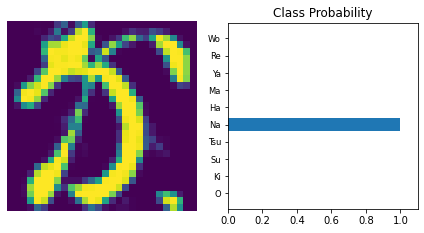

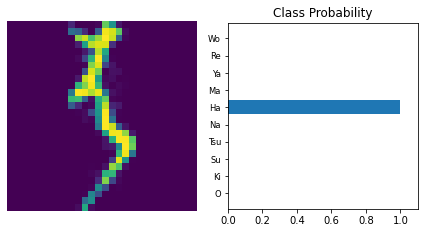

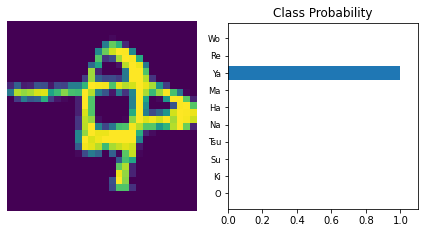

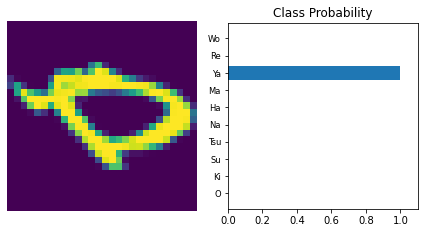

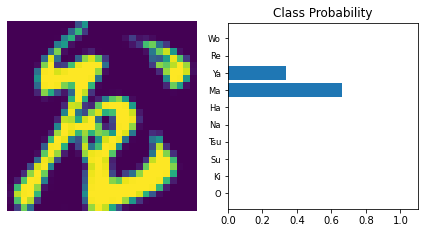

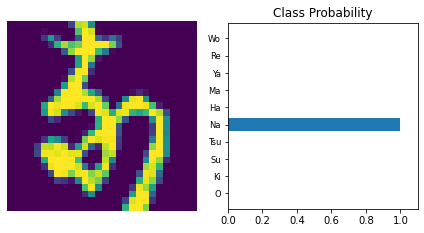

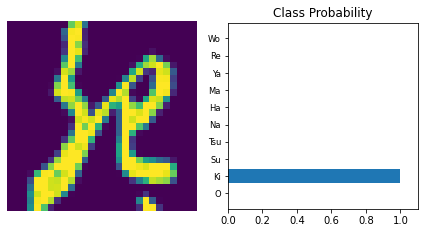

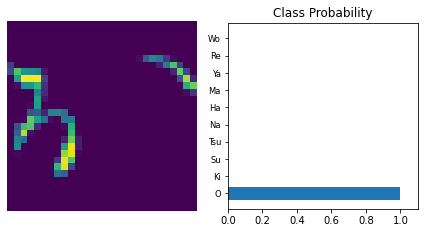

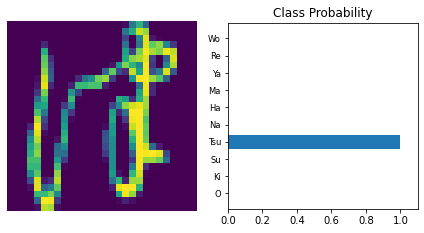

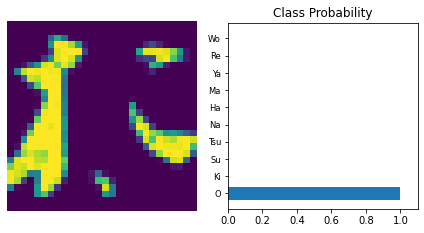

In [14]:
import matplotlib.pyplot as plt

def view_classify(img, ps):
    ps = ps.data.cpu().numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).cpu().numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes, size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
    
model.eval()
images, labels = next(iter(testloader))
for i in range(10):
    img = images[i]
    with torch.no_grad():
        images=images.to(device)
        logps = model(images)
    ps = torch.exp(logps[i])

    probab = list(ps.cpu().numpy())
    print("Clase predecida =", classes[probab.index(max(probab))])
    print("Clase correcta =", classes[labels[i]],"\n")

    view_classify(img.resize_(1, 28, 28), ps)

